# Using the <span style="color:#1F618D">CASCADe-filtering</span> package to determine the source position and define an extraction mask. #

This notebook shows the basic functions of the <span style="color:#1F618D">CASCADe-filtering</span> modules to detect the dispersed light profiles of astronomical targets in spectral data cubes. We show how to determine the general position and to derive an extraction mask. We also show how to determine the trace of the dispersed light using the <span style="color:#1F618D">CASCADe-filtering</span> modules. This package uses the basic filtering (convolution) fuctionality implemented in this package to calculate the Jacobian and Hessian matricii of the data. We then use the basic canny edge detector functionality to determine the extraction region, and use the Hessian  matrix to find the maxima of the dispersion profile and thus the spectral trace.

As example data, we use the set of simulated spectral images of MIRI LRS used in the example 2 notebook, for a  medium cosmic hit rate, which is also found in the examples directory of the <span style="color:#1F618D">CASCADe-filtering</span> package. Note that these data sets only contain a single target in the field of view. The <span style="color:#1F618D">CASCADe-filtering</span> package can, however, also identify multiple objects and derive individual extraction masks and positions.   

To run this example we first we import the relevant modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pathlib
import os

from cascade_filtering.filtering import DirectionalFilter
from cascade_filtering.kernel import FilterKernel
from cascade_filtering.filtering import EdgeFilter

from  cascade_filtering.utilities import create_mask_from_dq
from  cascade_filtering.utilities import find

from cascade_filtering.initialize import CASCADE_FILTERING_EXAMPLE_DIR

%matplotlib inline

we then define the paths to the filter kernel and edge filer configuration files and the simulated data.  

In [2]:
CONFIG_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'config_files/'

DATA_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'data/MIRI/LRS/medium_rate/'

CAL_DATA_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'data/MIRI/LRS/calibration_files/'

We then load the simulated data with low cosmic hit rate used in example 1.

In [3]:
files = find('*_rateints.fits', DATA_PATH)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    print(hdul.info())
    spectral_image_cube = hdul['SCI'].data
    spectral_image_uncertainty = hdul['ERR'].data
    spectral_image_mask = hdul['DQ'].data
spectral_image_cube = spectral_image_cube.astype(float)
spectral_image_uncertainty = spectral_image_uncertainty.astype(float)
spectral_image_mask = create_mask_from_dq(spectral_image_mask) 

Filename: /home/bouwman/CASCADeSTORAGE/examples_filtering/data/MIRI/LRS/medium_rate/det_image_with_medium_cosmics_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  SCI           1 ImageHDU        47   (72, 416, 10)   float32   
  2  ERR           1 ImageHDU        11   (72, 416, 10)   float32   
  3  DQ            1 ImageHDU        12   (72, 416, 10)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (72, 416, 10)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (72, 416, 10)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4212B]   
None


## Using  the <span style="color:#1F618D">CASCADe-filtering</span> edge filter class directly on the spectral data cube ##

It is in priciple possible to use the edge detection class of the <span style="color:#1F618D">CASCADe-filtering</span> package directly with the input data cube. The edge detection module implements a gaussian smoothing and tresholding which should make it reasonably robust against noise. In case of many and strong cosmic hits I would be advisable to employ the edge detection class on cleaned data, which we will demonstate in a second example in this notebook. 

The edge filter can be used in the following way:

In [4]:
EF = EdgeFilter(configuration_file='edge_filter.conf', path=CONFIG_PATH)
EF.run_filter(spectral_image_cube, spectral_image_mask)
EF.derive_source_location()

The `run_filter()` command runs the canny edge filter on the data cube determining a boundary box around the dispersed light profile. The results of this filtering can be extracted ftom the edge filter object as follows:

In [5]:
canny_edge_cube = EF.filtering_results.filtered_cube

and then plot the results for 2 different integrations:

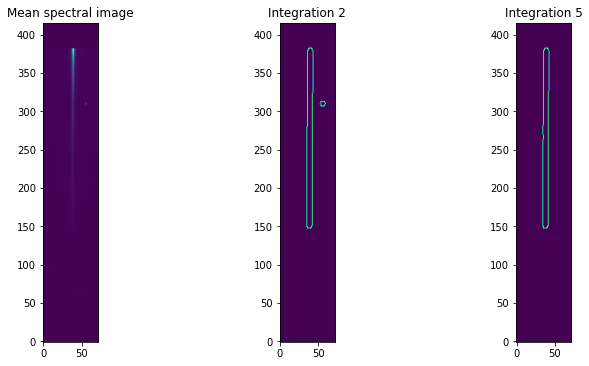

In [6]:
selected_integration = 2
canny_edge_image2 = canny_edge_cube[selected_integration, ...]
selected_integration = 5
canny_edge_image5 = canny_edge_cube[selected_integration, ...]

fig, ax = plt.subplots(1,3, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(np.mean(spectral_image_cube, axis=0), interpolation=None, origin='lower')
ax[0].set_title('Mean spectral image')
ax[1].imshow(canny_edge_image2, interpolation=None, origin='lower')
ax[1].set_title('Integration 2')
ax[2].imshow(canny_edge_image5, interpolation=None, origin='lower')
ax[2].set_title('Integration 5')
plt.show()

As one can see, the bounding box around the dispersed light of the target is clearly detected. However, for integration 2, also a cosmic hit is detected with the filtering method. We come back to this later when we discuss the impact of cosmics on source detection.

The second command `derive_source_location()` uses the boundary box to derive location masks and calculates the spectral trace as defined by the maximum of the dispersion profile. The source detection can locate multiple sources, for which ROI and source masks will be derived individually. In case the spectral data has multiple orders, or spectra of multiple spaxels, the source detection should in principle be able to detect those too. In this example, however, we only use one source with a single spectral order. One can check the number of detected sources in the following way: 

In [7]:
number_of_sources = EF.source_location.number_of_sources
print(number_of_sources)

1


 The derived region of interest (ROI) and source masks can be extracted in this way:

In [8]:
source_number = 0
ROI_filtering = EF.source_location.roi[source_number,...]
source_mask = EF.source_location.source_mask[source_number,...]

and the spectral trace:

In [9]:
spectral_trace = EF.source_location.source_traces[source_number]

Note that the source mask and spectral trace are determined for each intergation. To plot the masks and trace we pick an integration

In [10]:
selected_integration = 2
source_mask_integration2 = source_mask[selected_integration,...]
Xtrace2, Ytrace2 = spectral_trace[selected_integration]

selected_integration = 5
source_mask_integration5 = source_mask[selected_integration,...]
Xtrace5, Ytrace5 = spectral_trace[selected_integration]

and then plot derived ROI and the source extraction mask and trace for the 2 selected integrations:

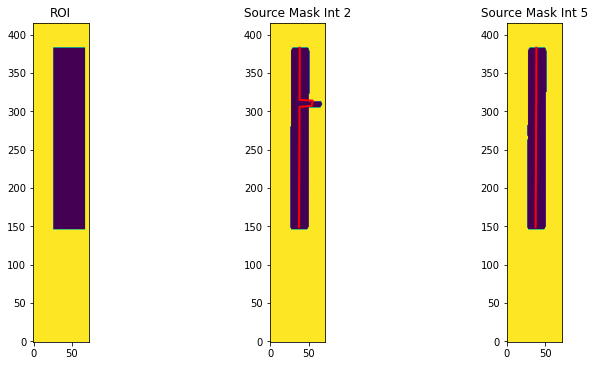

In [11]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(ROI_filtering, interpolation=None, origin='lower')
ax[0].set_title('ROI')
ax[1].plot(Xtrace2, Ytrace2, color='red', lw=2)
ax[1].imshow(source_mask_integration2, interpolation=None, origin='lower')
ax[1].set_title('Source Mask Int 2')
ax[2].plot(Xtrace5, Ytrace5, color='red', lw=2)
ax[2].imshow(source_mask_integration5, interpolation=None, origin='lower')
ax[2].set_title('Source Mask Int 5')
plt.show()

One can immediately see the problem when using the edge filter on the data directly in case of strong cosmic hits. While for integration 5 the trace and extraction mask are well defined, for integration 2 we see a substantial effect due to a strong cosmic hit at approximately detector row 310. We can also look at the center of light of the dispersion profile: 

In [12]:
selected_integration = 2
data = spectral_image_cube[selected_integration, ...]
nwav, npix = data.shape
extraction_mask = (~source_mask_integration2).astype(int)
weights = np.tile(np.arange(npix), (nwav, 1)).astype(float)
CM2 = np.sum(data*weights*extraction_mask,
            axis=(1))/(np.sum(data*extraction_mask, axis=(1))+1.e-14)

selected_integration = 5
data = spectral_image_cube[selected_integration, ...]
nwav, npix = data.shape
extraction_mask = (~source_mask_integration5).astype(int)
weights = np.tile(np.arange(npix), (nwav, 1)).astype(float)
CM5 = np.sum(data*weights*extraction_mask,
            axis=(1))/(np.sum(data*extraction_mask, axis=(1))+1.e-14)


and the input calibration file defining the spectral trace:

In [13]:
cal_file = 'MIRI_FM_MIRIMAGE_P750L_DISTORTION_07.02.00.fits'
with fits.open(CAL_DATA_PATH / cal_file) as hdul:
    X0 = hdul[0].header['IMXSLTL']
    Y0 = hdul[0].header['IMYSLTL'] - 528
    X_CENTER = hdul[1].data['X_CENTER']-0.5
    Y_CENTER = hdul[1].data['Y_CENTER']-0.5
    WAVELENGTH = hdul[1].data['WAVELENGTH']

and plot an comparison:

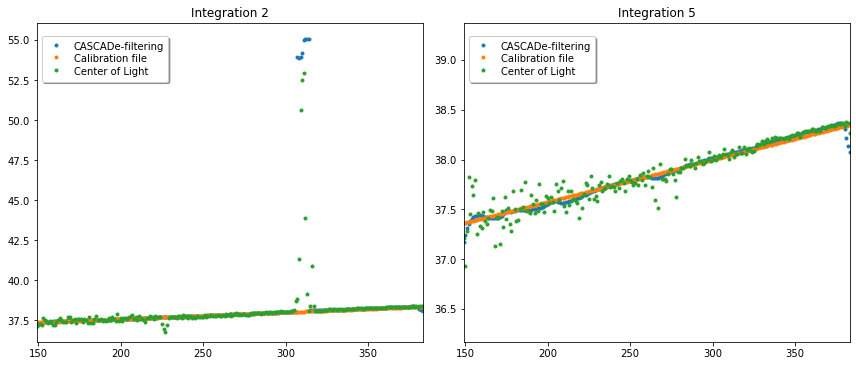

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.tight_layout(pad=1.0)
ax[0].plot(Ytrace2, Xtrace2, '.', label='CASCADe-filtering')
ax[0].plot(Y0+Y_CENTER, X0+X_CENTER, '.', label='Calibration file')
ax[0].plot(np.arange(nwav), CM2[:], '.', label='Center of Light')
ax[0].set_xlim([np.min(Ytrace2), np.max(Ytrace2)])
ax[0].set_ylim([np.min(Xtrace2)-1, np.max(Xtrace2)+1])
ax[0].legend(loc='lower left', fancybox=True, framealpha=1.0,
               ncol=1,
               bbox_to_anchor=(0, 0.80, 1, 0.2), shadow=True,
               handleheight=1.5, labelspacing=0.05,
               fontsize=10).set_zorder(11)
ax[0].set_title('Integration 2')
ax[1].plot(Ytrace5, Xtrace5, '.', label='CASCADe-filtering')
ax[1].plot(Y0+Y_CENTER, X0+X_CENTER, '.', label='Calibration file')
ax[1].plot(np.arange(nwav), CM5[:], '.', label='Center of Light')
ax[1].set_xlim([np.min(Ytrace5), np.max(Ytrace5)])
ax[1].set_ylim([np.min(Xtrace5)-1, np.max(Xtrace5)+1])
ax[1].legend(loc='lower left', fancybox=True, framealpha=1.0,
               ncol=1,
               bbox_to_anchor=(0, 0.80, 1, 0.2), shadow=True,
               handleheight=1.5, labelspacing=0.05,
               fontsize=10).set_zorder(11)
ax[1].set_title('Integration 5')
plt.show()

Which shows the excelent agreement with between the trace determined with the <span style="color:#1F618D">CASCADe-filtering</span> module for integration 5, which was not influenced by a cosmic hit, and the input (calibration file) dispersion profile. The effect on the trace determination of the cosmic hit in integration 2 can clearly seen in the left panel of the above figure. 

In principle (robustly) fitting a polynomial to the derived traces should allow for mitigating the noise introduced by a few cosmic hits. One can also try to adjust the filter parameters in the `edge_filter.conf` file to see if there is a more optimal setting which would prevent the detection of the cosmic hit. However, a robuster approach to overcome this problem would be to first clean the images of cosmics, and use the cleaned data cubes in the further analysis. In the next section we show how to do this.

## Using a 2D anisotropic filter first before determining the source positions and masks ##

To identify and remove the cosmic hits, we will use in this example the standard filter kernel set of <span style="color:#1F618D">CASCADe</span>, also used for Spitzer and HST data. This a set of 2D filters, consisting of in the dispersion direction elonggated gaussian kernels, and a few 'banana' shaped kernels to capture the shape of the end points of the spectral trace. Note that as this filter is 2D, not filtering in the time domain is applied. For more details on the filtering and other (3d) filter kernels we refere to the example notebooks 1 to 3 part of the <span style="color:#1F618D">CASCADe-filtering</span> examples. 

First we load the kernels:

In [15]:
FK = FilterKernel(configuration_file='banana_kernel.conf', path=CONFIG_PATH)
KERNEL_STACK = FK.kernel_stack

We also create a empty bad pixel mask and define the region of interest in the slitles sub array. Note that this mask can be relatively wide as the final mask will be determined after running the edge filter.

In [16]:
ROI = np.zeros_like(spectral_image_cube[0,...], dtype=bool)
ROI[:, :13] = True
ROI[:, 64:] = True
ROI[:120, :] =True
ROI[-20:, :] =True

We can now created a filter object, load the kernel stack and apply the filtering on the data.

In [17]:
DF = DirectionalFilter(sigma=4.0, max_iterations=39, acceptance_treshold=0.0001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 70
iteration: 2, number of flagged pixel: 1905
iteration: 3, number of flagged pixel: 558
iteration: 4, number of flagged pixel: 195
iteration: 5, number of flagged pixel: 81
iteration: 6, number of flagged pixel: 40
iteration: 7, number of flagged pixel: 23
Final number of still flagged pixel after iterations: 4
The acceptance limit is: 14


The cleaned and filered (smoothed) data cubes can be returned from the directional filter object as follows:

In [18]:
cleaned_image_cube, cleaned_image_cube_uncertainty, cleaned_image_cube_mask = DF.return_cleaned_data()
filtered_image_cube, filtered_image_cube_uncertainty, filtered_image_cube_mask = DF.return_filtered_data()

We will now use the cleaned dataset to perform the source finding and trace determinaton.

In [19]:
EF = EdgeFilter(configuration_file='edge_filter.conf', path=CONFIG_PATH)
EF.run_filter(cleaned_image_cube, cleaned_image_cube_mask)
EF.derive_source_location()

we can check that indeed only 1 source is found:

In [20]:
number_of_sources = EF.source_location.number_of_sources
print(number_of_sources)

1


 return the derived region of interest (ROI) and source masks:

In [21]:
source_number = 0
ROI_filtering = EF.source_location.roi[source_number,...]
source_mask = EF.source_location.source_mask[source_number,...]

and finally the spectral trace:

In [22]:
spectral_trace = EF.source_location.source_traces[source_number]

We again selelct integration 2 and 5

In [23]:
selected_integration = 2
source_mask_integration2 = source_mask[selected_integration,...]
Xtrace2, Ytrace2 = spectral_trace[selected_integration]

selected_integration = 5
source_mask_integration5 = source_mask[selected_integration,...]
Xtrace5, Ytrace5 = spectral_trace[selected_integration]

and then plot derived ROI and the source extraction mask and trace for the 2 selected integrations:

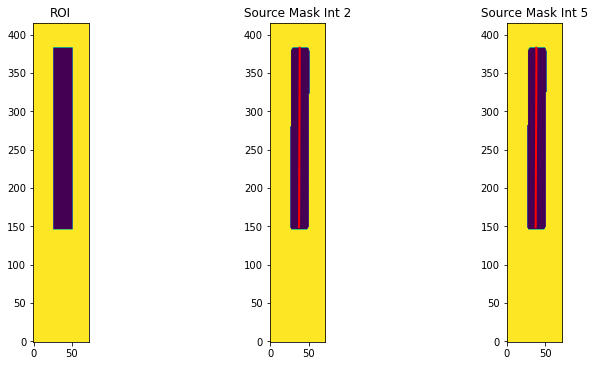

In [24]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(ROI_filtering, interpolation=None, origin='lower')
ax[0].set_title('ROI')
ax[1].plot(Xtrace2, Ytrace2, color='red', lw=2)
ax[1].imshow(source_mask_integration2, interpolation=None, origin='lower')
ax[1].set_title('Source Mask Int 2')
ax[2].plot(Xtrace5, Ytrace5, color='red', lw=2)
ax[2].imshow(source_mask_integration5, interpolation=None, origin='lower')
ax[2].set_title('Source Mask Int 5')
plt.show()

As one can see, after cleaning the data of cosmic hits, also for integration 2 we find the correct result. Looking again at the center of light of the dispersion profile: 

In [25]:
selected_integration = 2
data = cleaned_image_cube[selected_integration, ...]
nwav, npix = data.shape
extraction_mask = (~source_mask_integration2).astype(int)
weights = np.tile(np.arange(npix), (nwav, 1)).astype(float)
CM2 = np.sum(data*weights*extraction_mask,
            axis=(1))/(np.sum(data*extraction_mask, axis=(1))+1.e-14)

selected_integration = 5
data = cleaned_image_cube[selected_integration, ...]
nwav, npix = data.shape
extraction_mask = (~source_mask_integration5).astype(int)
weights = np.tile(np.arange(npix), (nwav, 1)).astype(float)
CM5 = np.sum(data*weights*extraction_mask,
            axis=(1))/(np.sum(data*extraction_mask, axis=(1))+1.e-14)


and plot an comparison:

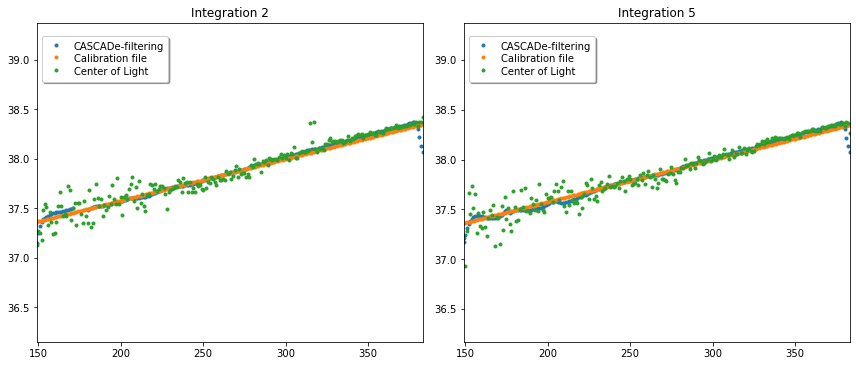

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.tight_layout(pad=1.0)
ax[0].plot(Ytrace2, Xtrace2, '.', label='CASCADe-filtering')
ax[0].plot(Y0+Y_CENTER, X0+X_CENTER, '.', label='Calibration file')
ax[0].plot(np.arange(nwav), CM2[:], '.', label='Center of Light')
ax[0].set_xlim([np.min(Ytrace2), np.max(Ytrace2)])
ax[0].set_ylim([np.min(Xtrace2)-1, np.max(Xtrace2)+1])
ax[0].legend(loc='lower left', fancybox=True, framealpha=1.0,
               ncol=1,
               bbox_to_anchor=(0, 0.80, 1, 0.2), shadow=True,
               handleheight=1.5, labelspacing=0.05,
               fontsize=10).set_zorder(11)
ax[0].set_title('Integration 2')
ax[1].plot(Ytrace5, Xtrace5, '.', label='CASCADe-filtering')
ax[1].plot(Y0+Y_CENTER, X0+X_CENTER, '.', label='Calibration file')
ax[1].plot(np.arange(nwav), CM5[:], '.', label='Center of Light')
ax[1].set_xlim([np.min(Ytrace5), np.max(Ytrace5)])
ax[1].set_ylim([np.min(Xtrace5)-1, np.max(Xtrace5)+1])
ax[1].legend(loc='lower left', fancybox=True, framealpha=1.0,
               ncol=1,
               bbox_to_anchor=(0, 0.80, 1, 0.2), shadow=True,
               handleheight=1.5, labelspacing=0.05,
               fontsize=10).set_zorder(11)
ax[1].set_title('Integration 5')
plt.show()

We now get a consistent result for all integrations, recovering the input spectral trace. Alternatively, one could also use the filtered image cube instead of the cleaned dataset. We leave this up to the user to try out. one will see that the results for the trace determination using the edge filter remain virtually unchanged while the center of light method benifits from the additional smooting. It will also demonstrate that the spatial profile in the smoothed dataset is indeed preserved. 